# Description

This is to play around with the basic blocks of a convolutional neural net.
The blocks are:
- convilutional: this is like applying a filter to an image
- max pool: this is to reduce the dimensionality of an image by splitting the image into blocks (e.g. groups of 4x4 pixels) and taking the max value of the block
- batch normalization: a batch of images is normalized using the z-score (i.e. subtract the mean and divide by the standard deviation)

# Load the libraries and set the parameters

In [1]:
import math,sys,os,numpy as np
from numpy.linalg import norm
from PIL import Image
from matplotlib import pyplot as plt, rcParams, rc
from scipy.ndimage import imread
from skimage.measure import block_reduce
import pickle
from scipy.ndimage.filters import correlate, convolve
#from ipywidgets import interact, interactive, fixed
#from ipywidgets.widgets import *

In [2]:
%matplotlib inline
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 6
%precision 4
np.set_printoptions(precision=4, linewidth=100)

plt.gray()
plt.close()

# Download the data
### Comment this block once the data has been downloaded

In [3]:
# from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets("MNIST_data/")
# images, labels = mnist.train.images, mnist.train.labels
# images = images.reshape((55000,28,28))
# np.savez_compressed("MNIST_data/train", images=images, labels=labels)

# Define the functions

In [4]:
def plots(ims, interp=False, titles=None):
    """
    Plot multiple images
    """
    ims = np.array(ims)
    mn, mx = ims.min(), ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp = f.add_subplot(1, len(ims), i+1)
        if not titles is None: 
            sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

def plot(im, interp=False, title=None):
    """
    Plot a single image
    """
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')
    if title is not None:
        plt.title(title)

# Load the data (images+labels)
We have 5000 images, each composed by 28x28 pixels. The images are in grayscale, so every pixel is just a number between 0 and 1.  
The labels are integers from 0 to 9.

In [5]:
data = np.load("MNIST_data/train.npz")
images = data['images']
labels = data['labels']
n = len(images)
images.shape

(55000, 28, 28)

In [6]:
images[0].shape

(28, 28)

# Give a look at the images

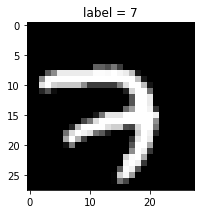

In [7]:
plot(images[0], title='label = {}'.format(labels[0]))

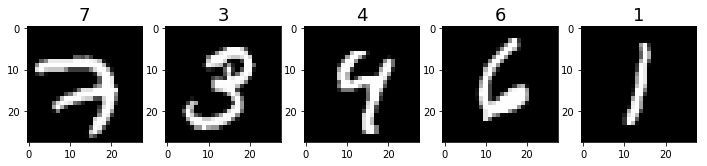

In [8]:
plots(images[:5], titles=labels[:5])

# Define a filter

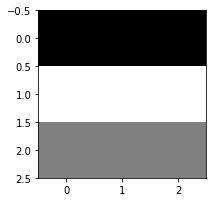

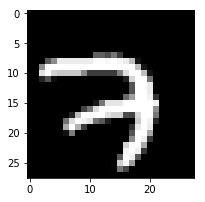

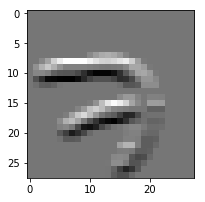

In [9]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

image0_original = images[0]

plot(top)
plot(images[0])
plot(correlate(images[0], top))

In [10]:
#plots([images[0], convolve(images[0], top)])

# Apply other filters

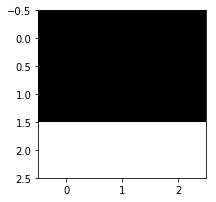

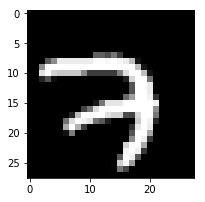

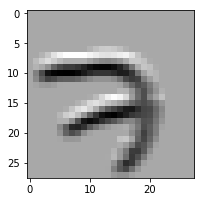

In [11]:
filter2 = [[-1,-1,-1],
           [-1,-1,-1],
           [ 1, 1, 1]]

plot(filter2)
plot(images[0])
plot(correlate(images[0], filter2))

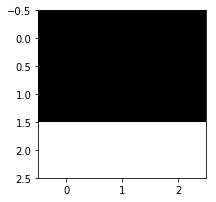

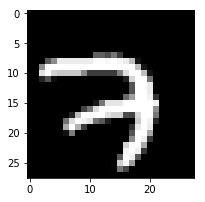

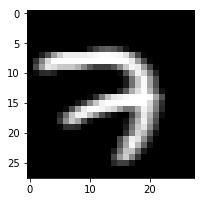

In [12]:
filter3 = [[ 0, 0, 0],
           [ 0, 0, 0],
           [ 1, 1, 1]]

plot(filter3)
plot(images[0])
plot(correlate(images[0], filter3))

# Create multiple filters using rotations of the first filter
This is used to "identify" straight lines

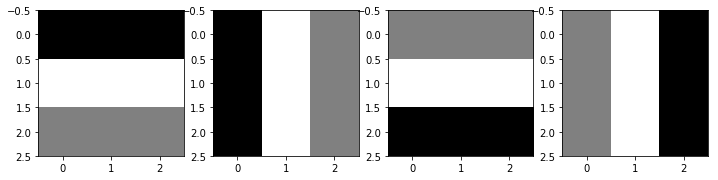

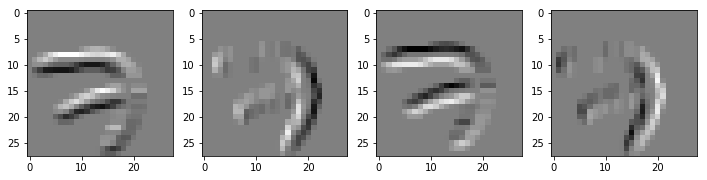

In [13]:
straights = [np.rot90(top,i) for i in range(4)]
plots(straights)
plots([correlate(images[0], straight) for straight in straights])

# Create multiple filters using rotations of a basic diagonal filter
This is used to identify diagonals

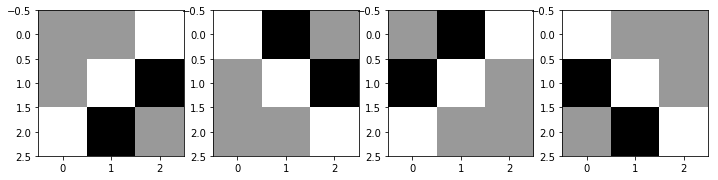

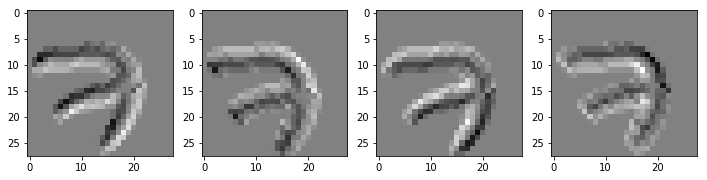

In [14]:
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
image0_diags = [correlate(images[0], diag) for diag in diags]
plots(diags)
plots(image0_diags)

# Create a max-pool block

In [15]:
def maxpool(im):
    """
    Let's split the image in 7x7 blocks and
    take the max value of each block.
    Since the original image is 28x28, this
    returns a 4x4 "reduced" image.
    """
    return block_reduce(im, (7,7), np.max)

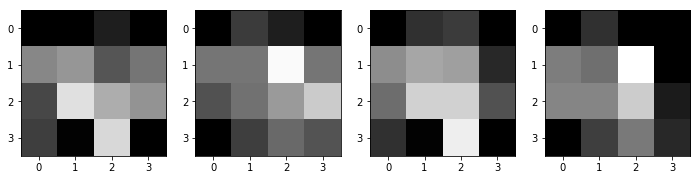

In [16]:
plots([maxpool(im) for im in image0_diags])

# Apply transformations (4 straights and 4 diagonals) + max-pool for 8s and 1s

In [17]:
transormations = straights + diags

In [18]:
eights = [images[i] for i in range(n) if labels[i]==8][:10]
ones = [images[i] for i in range(n) if labels[i]==1][:10]

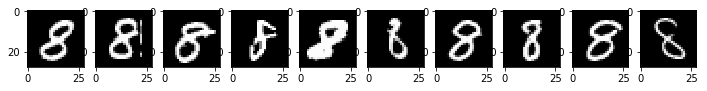

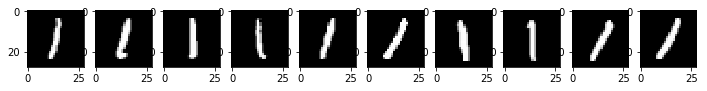

In [19]:
plots(eights)
plots(ones)

In [20]:
pool8 = [np.array([maxpool(correlate(im, tran)) for im in eights]) for tran in transormations]

In [21]:
len(pool8), pool8[0].shape

(8, (10, 4, 4))

In [22]:
pool1 = [np.array([maxpool(correlate(im, tran)) for im in ones]) for tran in transormations]

In [23]:
len(pool1), pool1[0].shape

(8, (10, 4, 4))

##### NOTE 
A single 28x28 has been tranformed into 10 images of 4x4 pixels each by:
1. applying the 10 different filters/tranformations (the results are 10 28x28 images)
2. applying the max-pool to each of the 10 images (the results are 10 4x4 images)

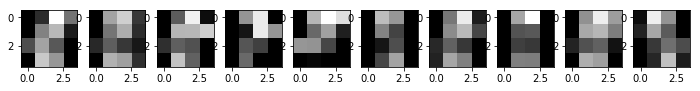

In [24]:
plots(pool8[0])

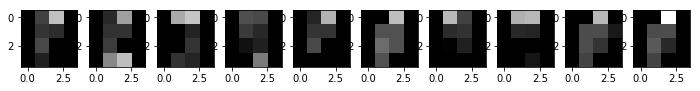

In [25]:
plots(pool1[0])

# Add a batch-normalization block
1 - the 10 images are merged together using the mean (i.e. all the [i,j] pixels of the 10 images are averaged together) - "in-normnalization"  
2 - the images of the batch are z-normalized - "intra-normalization"

In [26]:
def batch_normalize(arr):
    """
    This takes and array/batch of images and 
    return a normalized array/batch.
    """
    return (arr-arr.mean())/arr.std()

In [27]:
np.array(pool8).shape

(8, 10, 4, 4)

In [28]:
filts8 = np.array([img.mean(axis=0) for img in pool8])

In [29]:
np.array(filts8).shape

(8, 4, 4)

In [30]:
filts8 = batch_normalize(filts8)

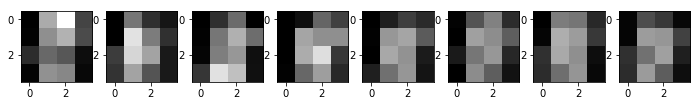

In [31]:
plots(filts8)

In [32]:
filts1 = np.array([ims.mean(axis=0) for ims in pool1])
filts1 = batch_normalize(filts1)

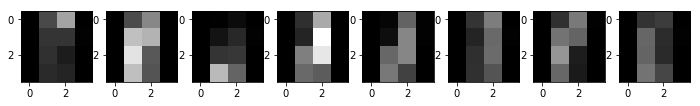

In [33]:
plots(filts1)

# Create a naive classification between 1s and 8s

In [34]:
def pool_corr(im): 
    """
    Apply the ten transformations + apply max_pool
    """
    return np.array([maxpool(correlate(im, tran)) for tran in transormations])

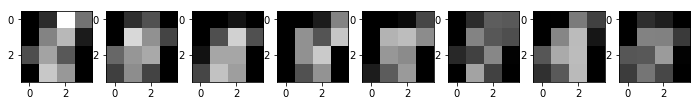

In [35]:
plots(pool_corr(eights[0]))

In [36]:
def sse(a,b):
    """
    Sum of squared errors
    """
    return ((a-b)**2).sum()


def is_1error_grater_than_8error(im):
    """
    This is a naive classification.
    Given an image, it calculates the error 
    (i.e. distance) between the image and the 1s 
    and the image and the 8s.
    """
    return int(sse(pool_corr(im),filts1) > sse(pool_corr(im),filts8))

In [38]:
print('error first 8 vs. all 8s:', sse(pool_corr(eights[0]), filts8))
print('error first 8 vs. all 1s:', sse(pool_corr(eights[0]), filts1))

error first 8 vs. all 8s: 123.101
error first 8 vs. all 1s: 187.029


In [39]:
[np.array([is_1error_grater_than_8error(im) for im in ims]).sum() for ims in [eights,ones]]

[10, 0]

In [41]:
def n1(a,b): return (np.fabs(a-b)).sum()
def is8_n1(im): return 1 if n1(pool_corr(im),filts1) > n1(pool_corr(im),filts8) else 0

In [42]:
[np.array([is8_n1(im) for im in ims]).sum() for ims in [eights,ones]]

[10, 0]